# Rotation

In [2]:
import numpy
import pandas
from matplotlib import pyplot
%matplotlib inline
%config InlineBackend.figure_format = "retina"

import modsim

### The Physics of Toilet Paper

In [3]:
Rmin = 0.02      # m
Rmax = 0.055     # m
L = 47           # m
omega = 300      # rad / s

In [4]:
Ravg = (Rmax + Rmin) / 2

In [7]:
Cavg = 2 * numpy.pi * Ravg # circumference of the roll

In [8]:
revs = L / Cavg # number of revolutions to roll up to length L

In [9]:
theta = 2 * numpy.pi * revs # rotations to radians
theta

1253.3333333333335

In [10]:
k_est = (Rmax - Rmin) / theta
k_est

2.7925531914893616e-05

### Simulating the System

In [11]:
init = modsim.State(theta=0, y=0, r=Rmin)

In [12]:
system = modsim.System(init=init, t_end=10)

In [13]:
def slope_func(t, state, system):
    theta, y, r = state
    
    dydt = r * omega
    drdt = k_est * omega
    
    return omega, dydt, drdt

In [14]:
slope_func(0, system.init, system)

(300, 6.0, 0.008377659574468085)

In [15]:
# Stop the simulation when the length of paper on the roll is L
def event_func(t, state, system):
    theta, y, r = state
    return L - y

In [16]:
event_func(0, system.init, system)

47.0

In [17]:
results, details = modsim.run_solve_ivp(system, slope_func, events=event_func)
details.message

'A termination event occurred.'

In [18]:
results.tail()

,theta,y,r
4.010667,1203.200000,44.277760,0.05360
4.052444,1215.733333,44.951740,0.05395
4.094222,1228.266667,45.630107,0.05430
4.136000,1240.800000,46.312860,0.05465
4.177778,1253.333333,47.000000,0.05500


In [20]:
results.index[-1] # time to complete one roll, seconds

4.177777777777779

In [21]:
final_state = results.iloc[-1] 
final_state.y # meters

47.00000000000001

In [22]:
final_state.r # Rmax in meters

0.05500000000000001

In [23]:
# Total number of rotations
radians = final_state.theta
rotations = radians / 2 / numpy.pi
rotations

199.47419534184218

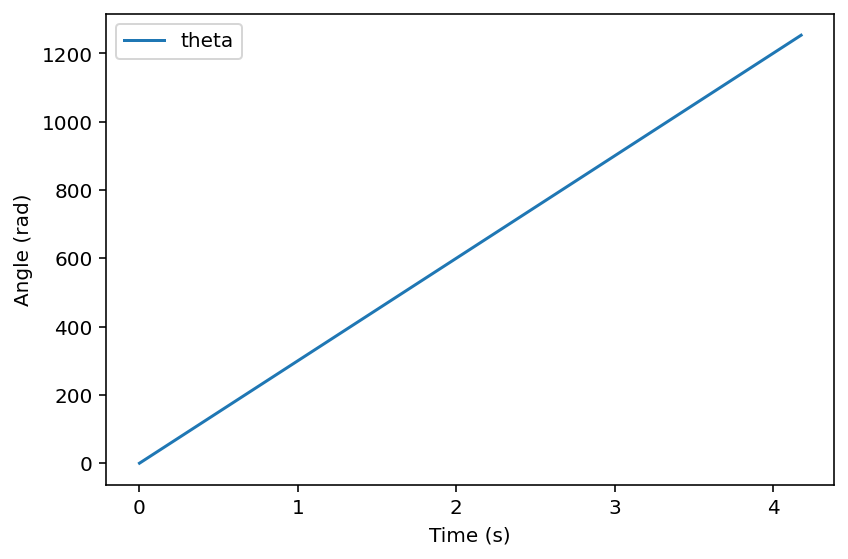

In [24]:
def plot_theta(results):
    results.theta.plot(color='C0', label='theta')
    modsim.decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

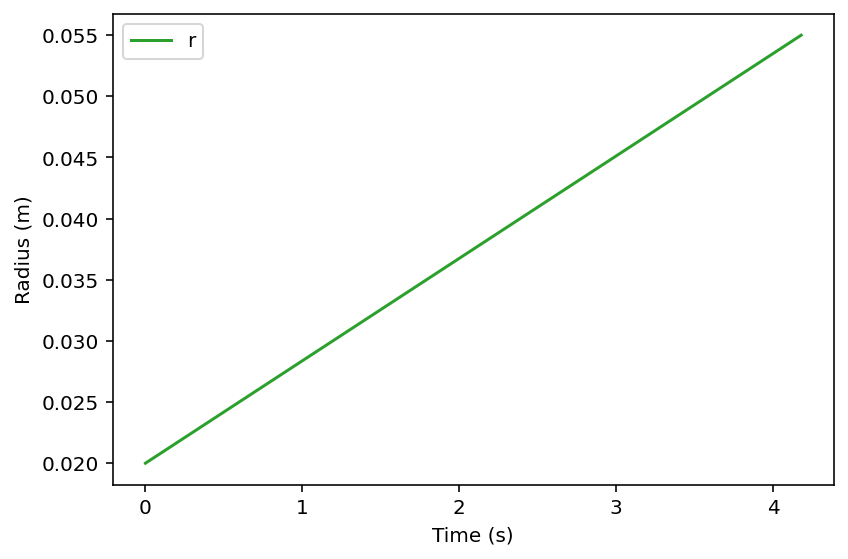

In [25]:
def plot_r(results):
    results.r.plot(color='C2', label='r')

    modsim.decorate(xlabel='Time (s)',
             ylabel='Radius (m)')
    
plot_r(results)

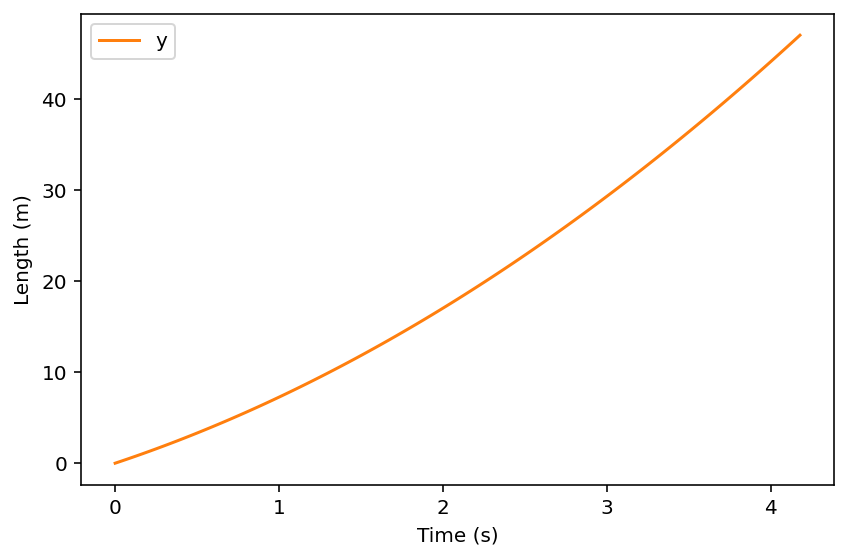

In [26]:
def plot_y(results):
    results.y.plot(color='C1', label='y')

    modsim.decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

### Analytic Solution

In [27]:
k = (Rmax**2 - Rmin**2) / (2 * L)
k

2.7925531914893616e-05

### Exercise 1
Since we keep `omega` constant, the linear velocity of the paper increases with radius. We can use `gradient` to estimate the derivative of `results.y`.

In [28]:
dydt = modsim.gradient(results.y)

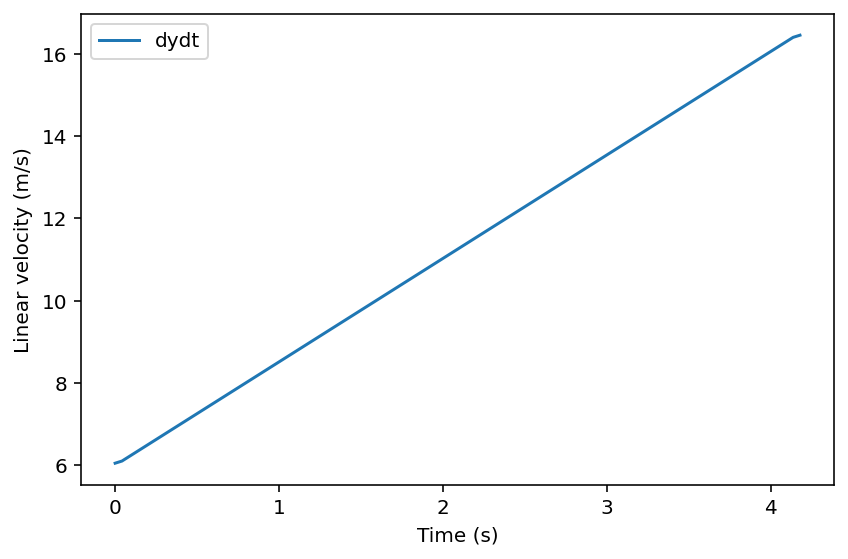

In [29]:
dydt.plot(label='dydt')
modsim.decorate(xlabel='Time (s)',
         ylabel='Linear velocity (m/s)')

With constant angular velocity, linear velocity is increasing, reaching its maximum at the end.

In [30]:
max_linear_velocity = dydt.iloc[-1]
max_linear_velocity

16.447499999999934

Now suppose this peak velocity is the limiting factor; that is, we can’t move the paper any faster than that. In that case, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly. Then, run the simulation and see how much faster we could finish rolling the paper.

In [51]:
def slope_func_2(t, state, system):
    theta, y, r = state

    epsilon = 1e-6
    
    dydt = system.max_velocity
    omega = dydt / (r + epsilon)
    drdt = k_est * omega
    
    return omega, dydt, drdt

In [52]:
system_2 = modsim.System(init=init, max_velocity=max_linear_velocity, t_end=10)

In [53]:
slope_func_2(0, system_2.init, system_2)

(822.3338833058314, 16.447499999999934, 0.022964111102955397)

In [54]:
results_2, details_2 = modsim.run_solve_ivp(system_2, slope_func_2, events=event_func)
details_2.message

'A termination event occurred.'

In [55]:
results_2.tail()

,theta,y,r
2.743274,1218.531950,45.12,0.054028
2.771850,1227.212264,45.59,0.054271
2.800426,1235.856276,46.06,0.054512
2.829001,1244.464403,46.53,0.054752
2.857577,1253.036954,47.00,0.054992


In [44]:
def get_final_results(results):
    time_to_complete_roll = results.index[-1]
    final_state = results.iloc[-1]
    Rmax = final_state.r
    # Total number of rotations
    radians = final_state.theta
    rotations = radians / 2 / numpy.pi
    return time_to_complete_roll, Rmax, rotations

In [47]:
time_complete, Rmax2, rotations2 = get_final_results(results_2)
time_complete, Rmax2, rotations2

(2.8575771393828964, 0.05499172344281488, 199.42702506799353)

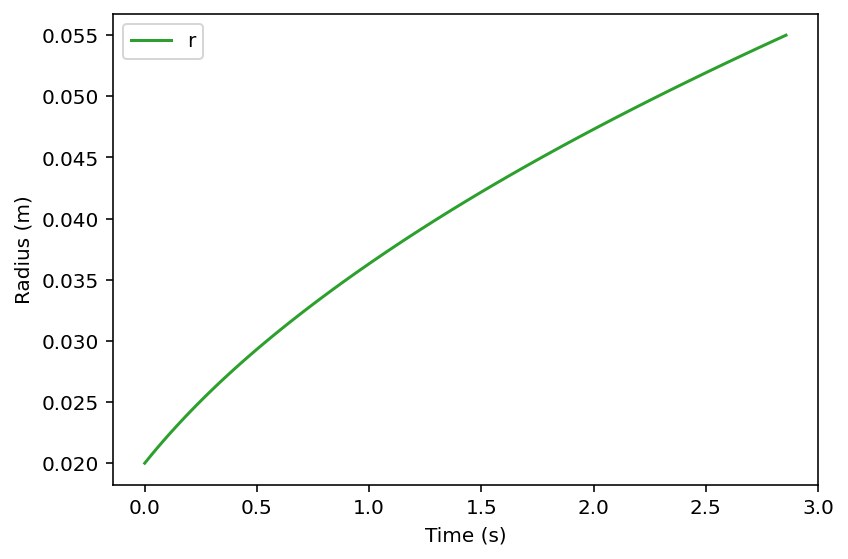

In [46]:
plot_r(results_2)

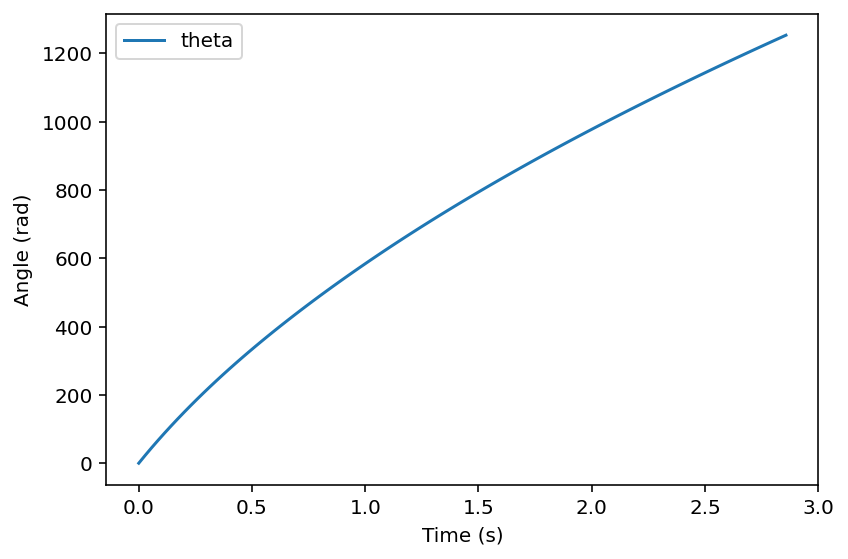

In [48]:
plot_theta(results_2)

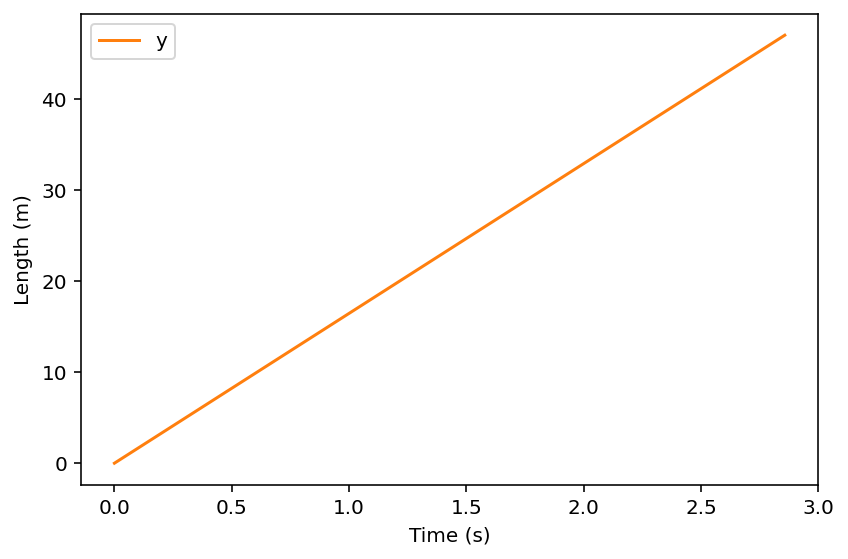

In [50]:
plot_y(results_2)